In [1]:
%matplotlib inline

In [2]:
import gridsim.grid_sim_linear_program as gslp
import gridsim.grid_sim_simple_example as gsse
import os.path as osp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Load profiles from California.  Profiles are for demand and non-dispatchable sources.

In [3]:
profiles_path = gsse.get_data_directory() + ['profiles', 'profiles_nyiso.csv']
profiles_file = osp.join(*profiles_path)
profiles = pd.read_csv(profiles_file, index_col=0, parse_dates=True)
profiles.columns

Index(['DEMAND', 'SOLAR', 'WIND', 'COAL', 'COAL_CRYO', 'COAL_AMINE',
       'NUCLEAR'],
      dtype='object')

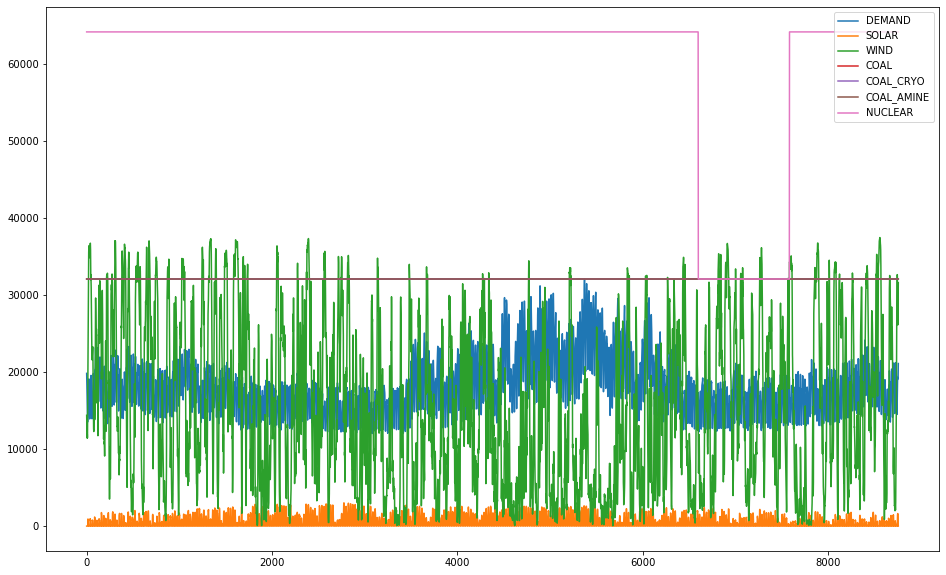

In [4]:
profiles.plot(figsize=(16, 10))

In [5]:
profiles

,DEMAND,SOLAR,WIND,COAL,COAL_CRYO,COAL_AMINE,NUCLEAR
0,19826.5,0.000000,14379.272178,32076.0,32076.0,32076.0,64152.0
1,19169.0,0.000000,13895.404051,32076.0,32076.0,32076.0,64152.0
2,18502.0,0.000000,13496.817131,32076.0,32076.0,32076.0,64152.0
3,17745.0,0.000000,13067.431391,32076.0,32076.0,32076.0,64152.0
4,16953.0,0.000000,12309.509794,32076.0,32076.0,32076.0,64152.0
...,...,...,...,...,...,...,...
8755,19256.0,1377.916667,26261.847463,32076.0,32076.0,32076.0,64152.0
8756,19097.0,803.850000,27953.312046,32076.0,32076.0,32076.0,64152.0
8757,19171.0,44.500000,29704.805402,32076.0,32076.0,32076.0,64152.0
8758,19918.0,0.000000,30780.249867,32076.0,32076.0,32076.0,64152.0


# Setup a Linear Program (LP) with DEMAND

In [6]:
lp = gslp.LinearProgramContainer(profiles)
lp.add_demands(gslp.GridDemand('DEMAND'))

In [7]:
# Simplest LP ever, add natural-gas source which is dispatchable so it can arbitrarily match demand
lp.add_dispatchable_sources(
      gslp.GridSource(
          name='NG',  # Dispatchable, so no name restriction.                                                                                                
          nameplate_unit_cost=1239031,  # Cost for a combined cycle plant. $/MW                                                                              
          variable_unit_cost=17.5,  # Cheap fuel costs assumes fracking. $/MWh                                                                               
          co2_per_electrical_energy=0.33,  # Tonnes CO2 / MWh                                                                                                
          is_rps_source=False))  # Not in Renewable Portfolio Standard.  

# Also adjust lp based upon what we think future costs are going to be.
hours_per_year = 24 * 365
annual_discount_rate = 0.06
lifetime_in_years = 30

lp.carbon_tax = 0 # No Carbon Tax
lp.rps_percent = 0 # No renewable requirement
lp.cost_of_money = gslp.extrapolate_cost(
  1.0,
  annual_discount_rate,
  lp.number_of_timeslices / hours_per_year,
  lifetime_in_years)

### Calling lp.solve() runs the linear program.  It returns True if the LP converged.

In [8]:
lp.solve()

True

### source_stats(lp) shows statistics about each source in the LP after the LP has converged.

In [9]:
def source_stats(lp):
    index = []
    capital = []
    variable = []
    co2_per_mwh = []
    nameplate = []
    generated = []
    
    for s in lp.sources:
        index.append(s.name)
        capital.append(s.nameplate_unit_cost)
        variable.append(s.variable_unit_cost)
        co2_per_mwh.append(s.co2_per_electrical_energy)
        nameplate.append(s.get_nameplate_solution_value())
        generated.append(sum(s.get_solution_values()))
        
    data = {'capital': capital,
           'variable': variable,
           'co2_per_mwh': co2_per_mwh,
           'nameplate': nameplate,
           'generated': generated}
    
    df = pd.DataFrame(index=index,
                      data=data)
    df['cost_of_money'] = lp.cost_of_money
    df['carbon_tax'] = lp.carbon_tax
    df['total_cost'] = (df.capital * df.nameplate +
                        df.cost_of_money * df.generated *
                        (df.variable + df.co2_per_mwh * df.carbon_tax))
    return df

In [10]:
lp.sources[2].name

IndexError: list index out of range

In [11]:
plt.plot(lp.sources[2].get_solution_values())

IndexError: list index out of range

In [12]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031,17.5,0.33,32076.0,160375697.5,14.590721,0,8.069311e+10


### plot_sources(lp) plots power / time of sources and demand.

In [13]:
def plot_labels(lp):
    plt.xlabel('Hour of Year')
    plt.ylabel('MegaWatts')
    
    title_string = 'Demand and Sources:'
    title_string += 'RPS = %d, Carbon Tax = %d' %(lp.rps_percent,
                                                 lp.carbon_tax)
    plt.title(title_string)
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    
def plot_sources(lp, slicee=None):
    if slicee is None:
        slicee = slice(lp.number_of_timeslices)
    profiles = lp.profiles
    plt.plot(profiles.index[slicee], 
             profiles.DEMAND[slicee], label='Demand')
    for source in lp.sources:
        plt.plot(profiles.index[slicee],
                 source.get_solution_values()[slicee], label=source.name)
    plot_labels(lp)

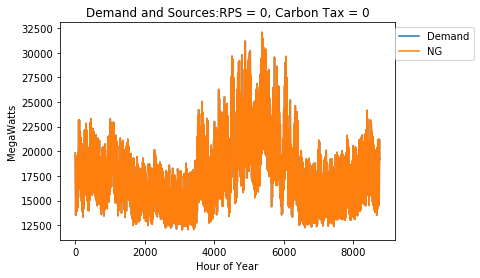

In [14]:
plot_sources(lp)

### Above run is not very interesting because there's only one source so it must match Demand identically

# Add Solar

In [15]:
solar = gslp.GridSource(
      name='SOLAR',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=946000,  # Aggressive solar cost $/MW                                                                                          
      variable_unit_cost=0,  # No fuel cost.                                                                                                             
      co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
      is_rps_source=True)  # In Renewable Portfolio Standard 

lp.add_nondispatchable_sources(solar)     
lp.solve()

True

In [16]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031,17.5,0.33,31591.971794,1.588996e+08,14.590721,0,7.971647e+10
SOLAR,946000,0.0,0.00,925.567394,1.476137e+06,14.590721,0,8.755868e+08


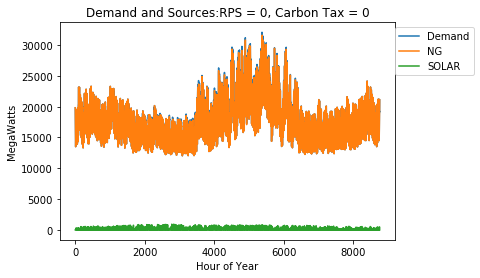

In [17]:
plot_sources(lp)

### Still only Natural Gas (NG) because NG is cheaper than Solar and he LP will generate the cheapest power subject to the constraints.

# Increase Renewable Portfolio Standard (RPS) % which mandates what % comes from renewables.

In [18]:
lp.rps_percent = 30
lp.solve()

True

In [19]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031,17.5,0.33,30051.914911,1.122630e+08,14.590721,0,6.590022e+10
SOLAR,946000,0.0,0.00,32942.921542,5.253888e+07,14.590721,0,3.116400e+10


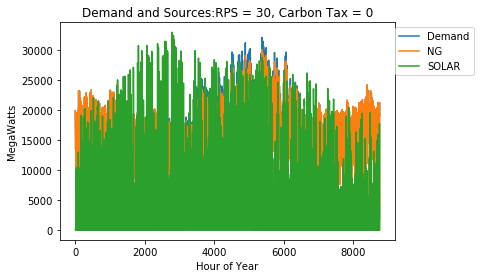

In [20]:
plot_sources(lp)

### Above is lots of data, and a little confusing, so let's slice it down somewhat.
### Here's 200 hours in the middle of the year. (Note hours are UTC)

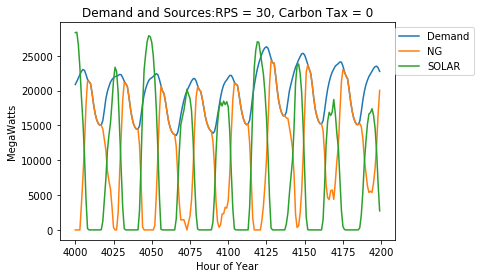

In [21]:
plot_sources(lp,slice(4000,4200))

# Add Wind to see how the LP handles Solar and Wind as RPS

In [22]:
wind = gslp.GridSource(
      name='WIND',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=2051532,  # Aggressive wind cost $/MW                                                                                          
      variable_unit_cost=0,  # No fuel cost.                                                                                                             
      co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
      is_rps_source=True)  # In Renewable Portfolio Standard 
lp.add_nondispatchable_sources(wind)
     
lp.solve()

True

In [23]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031,17.5,0.33,28217.577433,1.122630e+08,14.590721,0,6.362742e+10
SOLAR,946000,0.0,0.00,7408.366532,1.181520e+07,14.590721,0,7.008315e+09
WIND,2051532,0.0,0.00,10019.137667,3.630028e+07,14.590721,0,2.055458e+10


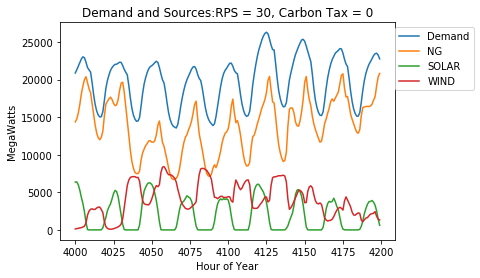

In [24]:
plot_sources(lp,slice(4000,4200))

### Solar is so much cheaper than wind (at a very futuristic price) so that no wind is used.

# Bring Solar Costs Back Somewhat to Present Day.

In [25]:
solar.nameplate_unit_cost = 1.5e6 # $ / Mw
lp.solve()

True

In [26]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031.0,17.5,0.33,29108.368293,1.122630e+08,14.590721,0,6.473113e+10
SOLAR,1500000.0,0.0,0.00,0.000000,0.000000e+00,14.590721,0,0.000000e+00
WIND,2051532.0,0.0,0.00,13279.596606,4.811323e+07,14.590721,0,2.724352e+10


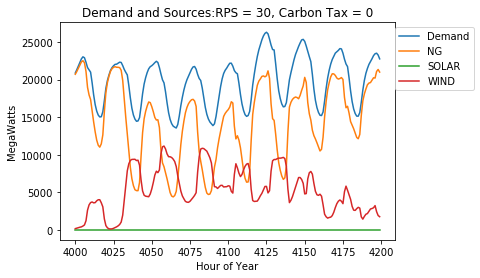

In [27]:
plot_sources(lp,slice(4000,4200))

### Some wind is now showing up.

# Increase rps_percent and Watch the Wind / Solar Distribution.

In [28]:
lp.rps_percent = 60
lp.solve()

True

In [29]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031.0,17.5,0.33,26819.299348,6.415028e+07,14.590721,0,4.960992e+10
SOLAR,1500000.0,0.0,0.00,9072.207902,1.446877e+07,14.590721,0,1.360831e+10
WIND,2051532.0,0.0,0.00,25520.700776,9.246391e+07,14.590721,0,5.235653e+10


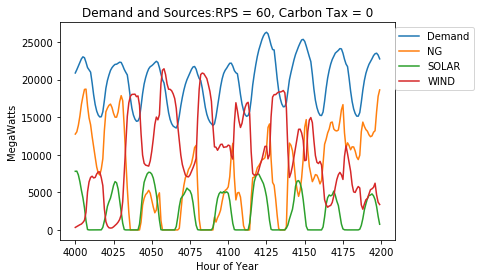

In [30]:
plot_sources(lp,slice(4000,4200))

### Solar Capacity slightly decreased 28GW -> 25GW 
### Wind Capacity surged 6GW -> 40GW

# Add Storage 

In [31]:
# Note: solving takes somewhat more time with storage
storage = gslp.GridRecStorage(
    name='STORAGE',
    storage_nameplate_cost=187000, # $ / Mwh of storage capacity
    charge_nameplate_cost=100000, # $ / Mw of charging capacity
    discharge_nameplate_cost=100000, # $ / Mw of discharging capacity
    charge_efficiency=0.9,
    discharge_efficiency=0.9,
    storage_efficiency=1.0)
lp.add_storage(storage)
lp.solve()

True

In [32]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031.0,17.5,0.33,23358.736344,6.444946e+07,14.590721,0,4.539857e+10
SOLAR,1500000.0,0.0,0.00,7205.785123,1.149212e+07,14.590721,0,1.080868e+10
WIND,2051532.0,0.0,0.00,25951.666646,9.402534e+07,14.590721,0,5.324067e+10


In [33]:
# Helper function to show cost and usage information for storage.

def storage_stats(lp):
    index = []
    capital_charge = []
    capital_discharge = []
    capital_storage = []
    storage_capacity = []
    charge_capacity = []
    discharge_capacity = []
    
    for s in lp.storage:
        index.append(s.name)
        capital_charge.append(s.charge_nameplate_cost)
        capital_discharge.append(s.discharge_nameplate_cost)
        capital_storage.append(s.storage_nameplate_cost)
        storage_capacity.append(s.energy_nameplate.solution_value())
        charge_capacity.append(s.charge_nameplate.solution_value())
        discharge_capacity.append(s.discharge_nameplate.solution_value())
    df = pd.DataFrame(index=index,
                     data={'capital_charge': capital_charge,
                           'capital_storage': capital_storage,
                           'capital_discharge': capital_discharge,
                           'storage_capacity': storage_capacity,
                           'charge_capacity': charge_capacity,
                           'discharge_capacity': discharge_capacity
                           })
    df['total_cost'] = (df.capital_storage * df.storage_capacity +
                        df.capital_charge * df.charge_capacity +
                        df.capital_discharge * df.discharge_capacity)
    return df

In [34]:
storage_stats(lp)

,capital_charge,capital_storage,capital_discharge,storage_capacity,charge_capacity,discharge_capacity,total_cost
STORAGE,100000,187000,100000,17146.832306,1354.197565,4104.792497,3.752357e+09


In [35]:
# Helper function to plot storage results.
# Negative numbers mean power from grid to storage.
# Positive numbers mean power from storage to grid.
def plot_storage(lp, slicee=None):
    if slicee is None:
        slicee = slice(lp.number_of_timeslices)
    profiles = lp.profiles
    for storage in lp.storage:
        name = storage.name
        charging_variables = (
            storage.rec_storage.sink.get_solution_values() + 
            storage.no_rec_storage.sink.get_solution_values())
        discharging_variables = (
            storage.rec_storage.source.get_solution_values() + 
            storage.no_rec_storage.source.get_solution_values())
        
        plt.plot(profiles.index[slicee],
                 discharging_variables[slicee]
                 -charging_variables[slicee], 
                 label='%s to grid' % name)
    plot_labels(lp)

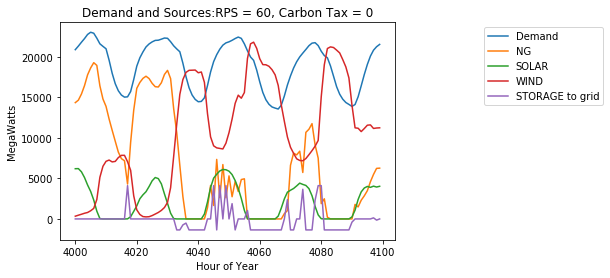

In [36]:
s = slice(4000,4100)
plot_sources(lp,s)
plot_storage(lp,s)

### Negative Storage_to_grid means storage is charging from grid.
### Positive Storage_to_grid means storage is powering grid

# Increase rps_percent to 90%.
### Storage may be needed for extremely high rps_percentages.

In [37]:
lp.rps_percent = 90
lp.solve()

True

In [38]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031.0,17.5,0.33,13323.405681,1.732726e+07,14.590721,0,2.093241e+10
SOLAR,1500000.0,0.0,0.00,42489.603108,6.776436e+07,14.590721,0,6.373440e+10
WIND,2051532.0,0.0,0.00,36629.433338,1.327119e+08,14.590721,0,7.514645e+10


In [39]:
storage_stats(lp)

,capital_charge,capital_storage,capital_discharge,storage_capacity,charge_capacity,discharge_capacity,total_cost
STORAGE,100000,187000,100000,142459.573073,8488.434012,12481.682391,2.873695e+10


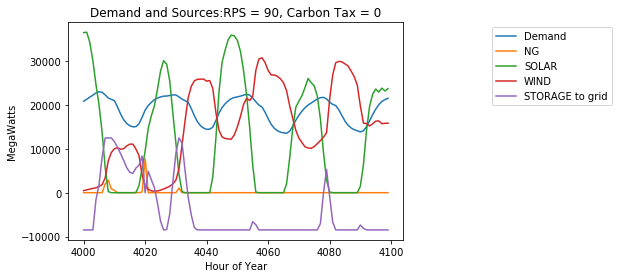

In [40]:
s = slice(4000,4100)
plot_sources(lp,s)
plot_storage(lp,s)